In [40]:
from sklearn.datasets import fetch_20newsgroups
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import string
import urllib
import zipfile
import sys

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=4, suppress=True)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

## 9

Loaded documents of all 20 categories from 20Newsgroups.

min_df = 3, exculded stopwords, removed headers and footers.

SVD to reduce dimensions of TF-IDF matrix with n_components = 1000

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
news_data = fetch_20newsgroups(
    subset='all',
    shuffle=True, 
    random_state=RANDOM_SEED,
    remove=('header', 'footer')
)

inputs = news_data.data
labels = news_data.target

target_names = news_data.target_names

In [43]:
tfidf_vectorizer = TfidfVectorizer(min_df=3, stop_words='english')

inputs_tfidf = tfidf_vectorizer.fit_transform(inputs)
print("inputs_tfidf.shape:", inputs_tfidf.shape)

inputs_tfidf.shape: (18846, 52295)


In [44]:
from sklearn.decomposition import TruncatedSVD

Visualized the variance explained by upto 1000 components. They seem to explain almost 50% of the variance in input data, and each further component explains a very small fraction of the variance.

In [45]:
svd = TruncatedSVD(n_components=1000,random_state=RANDOM_SEED)
inputs_svd = svd.fit_transform(inputs_tfidf)

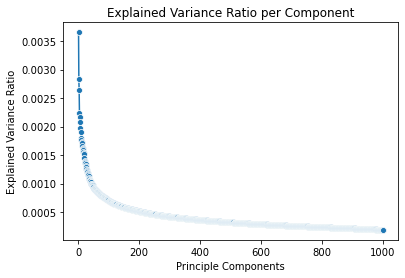

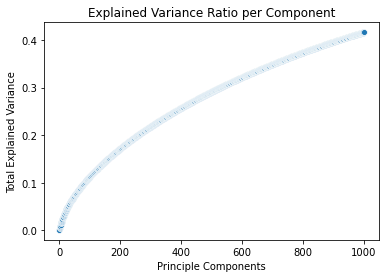

In [46]:
xs = np.arange(1,1001)
ys = sorted(svd.explained_variance_ratio_, reverse=True)
ys_cum = np.cumsum(svd.explained_variance_ratio_)

g = sns.lineplot(
    x=xs, 
    y=ys,
    marker='o'
)
g.set_xlabel('Principle Components')
g.set_ylabel('Explained Variance Ratio')
g.set_title('Explained Variance Ratio per Component')
plt.show()

g = sns.lineplot(
    x=xs, 
    y=ys_cum,
    marker='o'
)
g.set_xlabel('Principle Components')
g.set_ylabel('Total Explained Variance')
g.set_title('Explained Variance Ratio per Component')
plt.show()

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (
    contingency_matrix, 
    homogeneity_score, 
    v_measure_score, 
    completeness_score, 
    adjusted_rand_score, 
    adjusted_mutual_info_score
)
from plotmat import plot_mat

In [49]:
def get_cluster_metrics(y_true, y_pred, metrics=None):
    if not metrics:
        metrics = [
            homogeneity_score,
            completeness_score,
            v_measure_score,
            adjusted_rand_score,
            adjusted_mutual_info_score
        ]
    d = {}
    for m in metrics:
        d[m.__name__] = m(y_true, y_pred)
    df = pd.DataFrame(d, index=[0]).T
    df.reset_index(inplace=True)
    df.rename(columns={'index':'metric', 0:'score'}, inplace=True)
    return df

Using n_components = [1, 2, 3, 5, 10, 20, 50, 100, 300, 500, 800] test the multi class classification:

In [53]:
km = KMeans(
    n_clusters= len(target_names), 
    random_state=0,
    max_iter=5000,
    n_init=50
)

In [54]:
scores = []
n_components = [1, 2, 3, 5, 10, 20, 50, 100, 300, 500, 800]
for r in n_components:
    inputs_svd = TruncatedSVD(n_components=r, random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
    preds = km.fit_predict(inputs_svd)
    scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=metrics, index=n_components)
metrics_df

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
1,0.027941,0.031138,0.029453,0.005799,0.026110
2,0.211032,0.224915,0.217753,0.064692,0.215137
3,0.232702,0.242342,0.237424,0.079573,0.234909
5,0.313221,0.332460,0.322554,0.123212,0.320297
10,0.339986,0.379278,0.358559,0.139547,0.356361
20,0.287669,0.383175,0.328624,0.092857,0.326112
50,0.310314,0.413422,0.354523,0.093870,0.352104
100,0.275215,0.381518,0.319763,0.083114,0.317164
300,0.299456,0.402700,0.343488,0.098837,0.340994
500,0.284961,0.451065,0.349270,0.087328,0.346626


Using n_components = 2 in SVD, because it was the best decomposer for the previous binary classification task:

In [55]:
svd = TruncatedSVD(n_components = 2, random_state=RANDOM_SEED)
inputs_svd = svd.fit_transform(inputs_tfidf)

In [56]:
km = KMeans(
    n_clusters= len(target_names), 
    random_state=0,
    max_iter=5000,
    n_init=50
)
preds = km.fit_predict(inputs_svd)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.211032
1,completeness_score,0.224915
2,v_measure_score,0.217753
3,adjusted_rand_score,0.064692
4,adjusted_mutual_info_score,0.215137


In [ ]:
from scipy.optimize import linear_sum_assignment

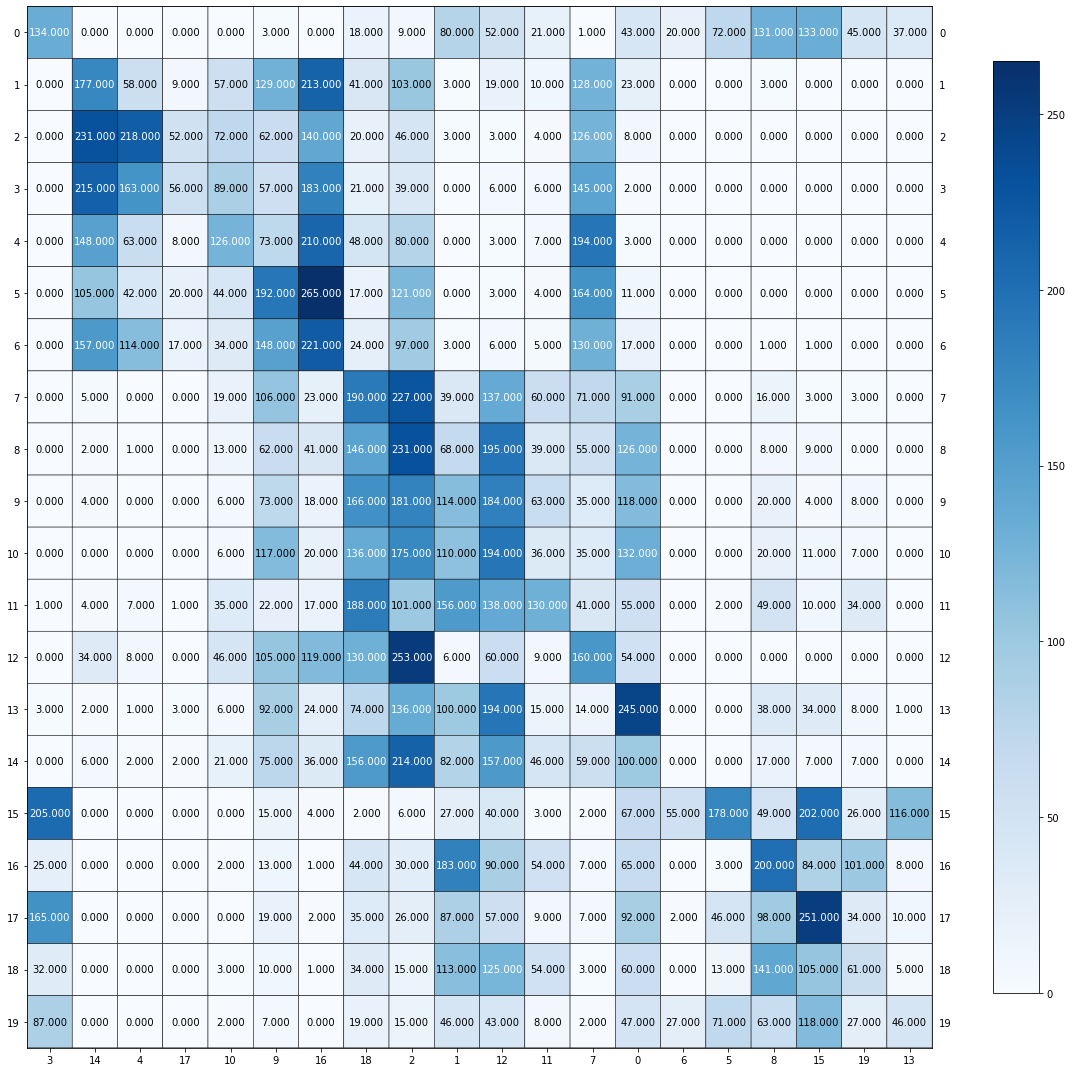

In [57]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

Using SVD n_components = 20 (number of classes present):

In [58]:
svd = TruncatedSVD(n_components = len(target_names), random_state=RANDOM_SEED)
inputs_svd = svd.fit_transform(inputs_tfidf)
km = KMeans(
    n_clusters= len(target_names), 
    random_state=0,
    max_iter=5000,
    n_init=50
)
preds = km.fit_predict(inputs_svd)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.287669
1,completeness_score,0.383175
2,v_measure_score,0.328624
3,adjusted_rand_score,0.092857
4,adjusted_mutual_info_score,0.326112


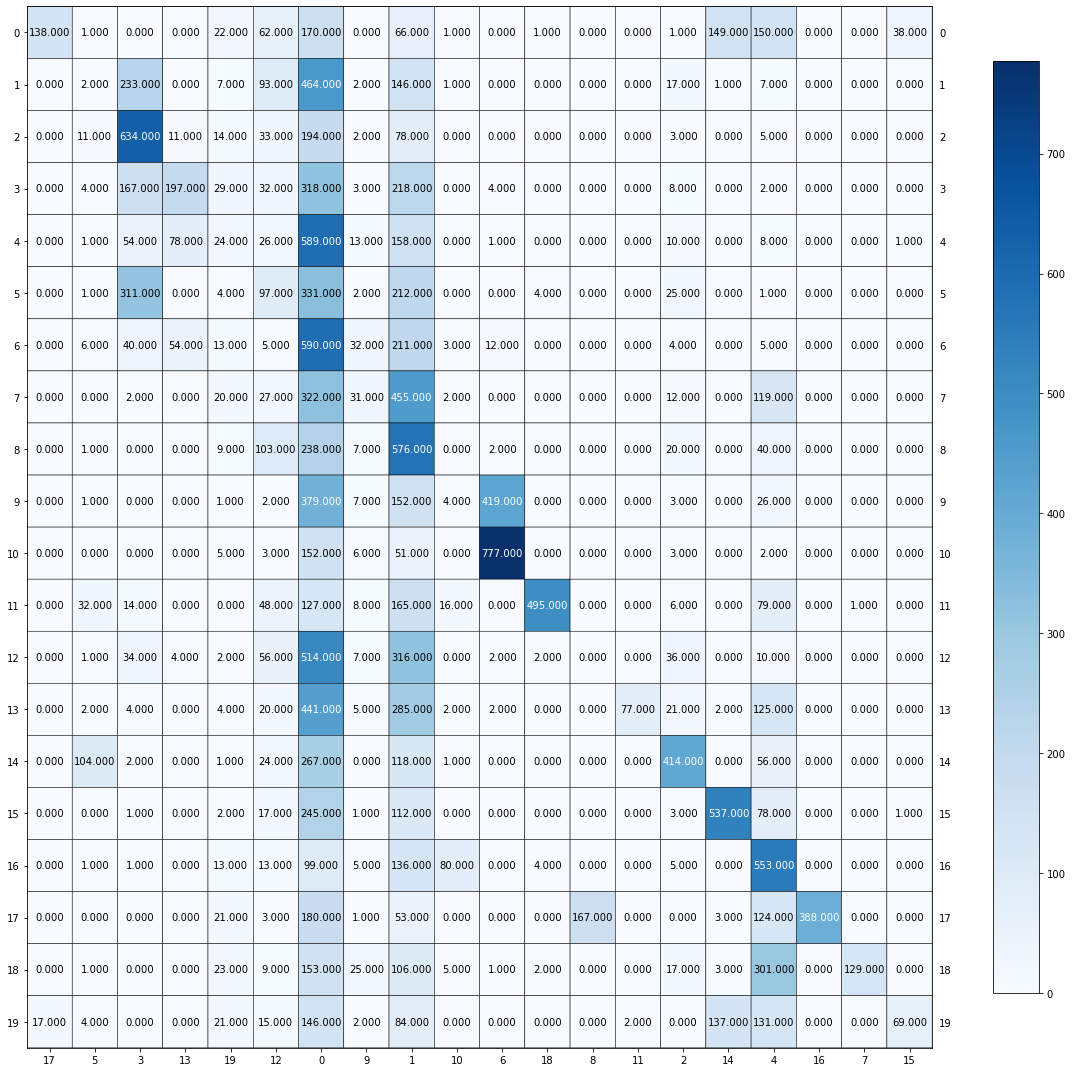

In [59]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

Using SVD n_components = 200 to check if it would improve the classifiation metrics:

In [60]:
svd = TruncatedSVD(n_components = 200, random_state=RANDOM_SEED)
inputs_svd = svd.fit_transform(inputs_tfidf)
km = KMeans(
    n_clusters= len(target_names), 
    random_state=0,
    max_iter=5000,
    n_init=50
)
preds = km.fit_predict(inputs_svd)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.236020
1,completeness_score,0.409269
2,v_measure_score,0.299387
3,adjusted_rand_score,0.060161
4,adjusted_mutual_info_score,0.296418


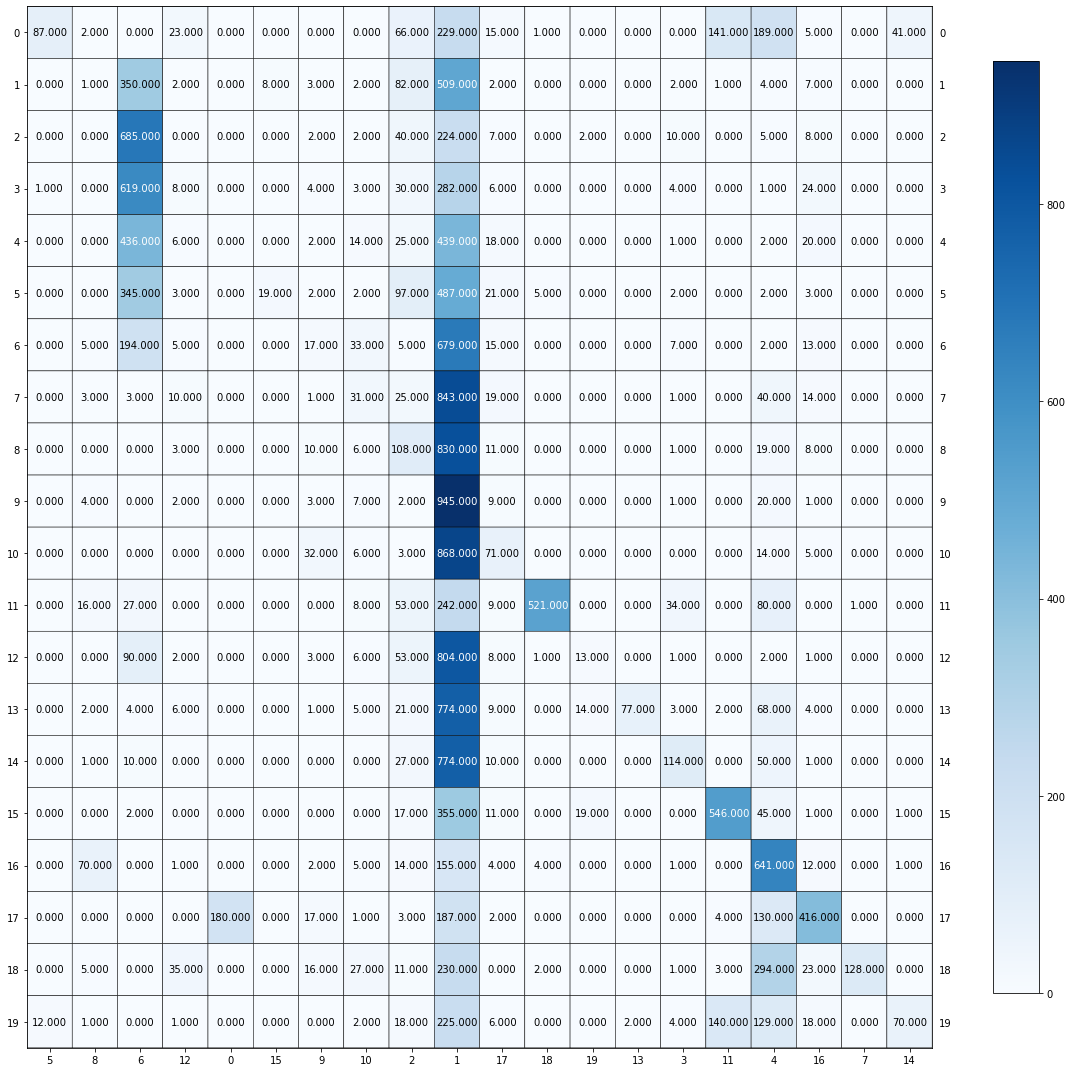

In [61]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

## 10
Using NMF decomposition, with Kullback-Leibler divergence as the distance measure

In [62]:
from sklearn.decomposition import NMF

In [63]:
km = KMeans(
    n_clusters=len(target_names), 
    random_state=0,
    max_iter=5000,
    n_init=50
)

Checking which n_components gives better results when used NMF decompostion with KL divergence

In [64]:
scores = []
n_components = [1, 2, 3, 5, 10, 20, 50, 100, 300]
for r in n_components:
    inputs_nmf = NMF(n_components=r, init='random', solver = 'mu', beta_loss = 'kullback-leibler', random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
    preds = km.fit_predict(inputs_nmf)
    scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=metrics, index=n_components)
metrics_df

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
1,0.030556,0.034513,0.032414,0.006957,0.029031
2,0.198715,0.225536,0.211277,0.063138,0.208523
3,0.256536,0.278224,0.266940,0.093704,0.264456
5,0.350546,0.374438,0.362098,0.155914,0.359949
10,0.405617,0.414149,0.409838,0.210817,0.407913
20,0.382709,0.392057,0.387327,0.252586,0.385325
50,0.239701,0.342298,0.281956,0.046972,0.279203
100,0.199862,0.389404,0.264149,0.028596,0.260931
300,0.042846,0.231684,0.072318,0.002391,0.066781


The best scores were obtained for n_components = 10. The contingency matrix in that case would be:

In [65]:
inputs_nmf = NMF(n_components=10, init='random', solver = 'mu', beta_loss = 'kullback-leibler', random_state=RANDOM_SEED).fit_transform(inputs_tfidf)
preds = km.fit_predict(inputs_nmf)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.405617
1,completeness_score,0.414149
2,v_measure_score,0.409838
3,adjusted_rand_score,0.210817
4,adjusted_mutual_info_score,0.407913


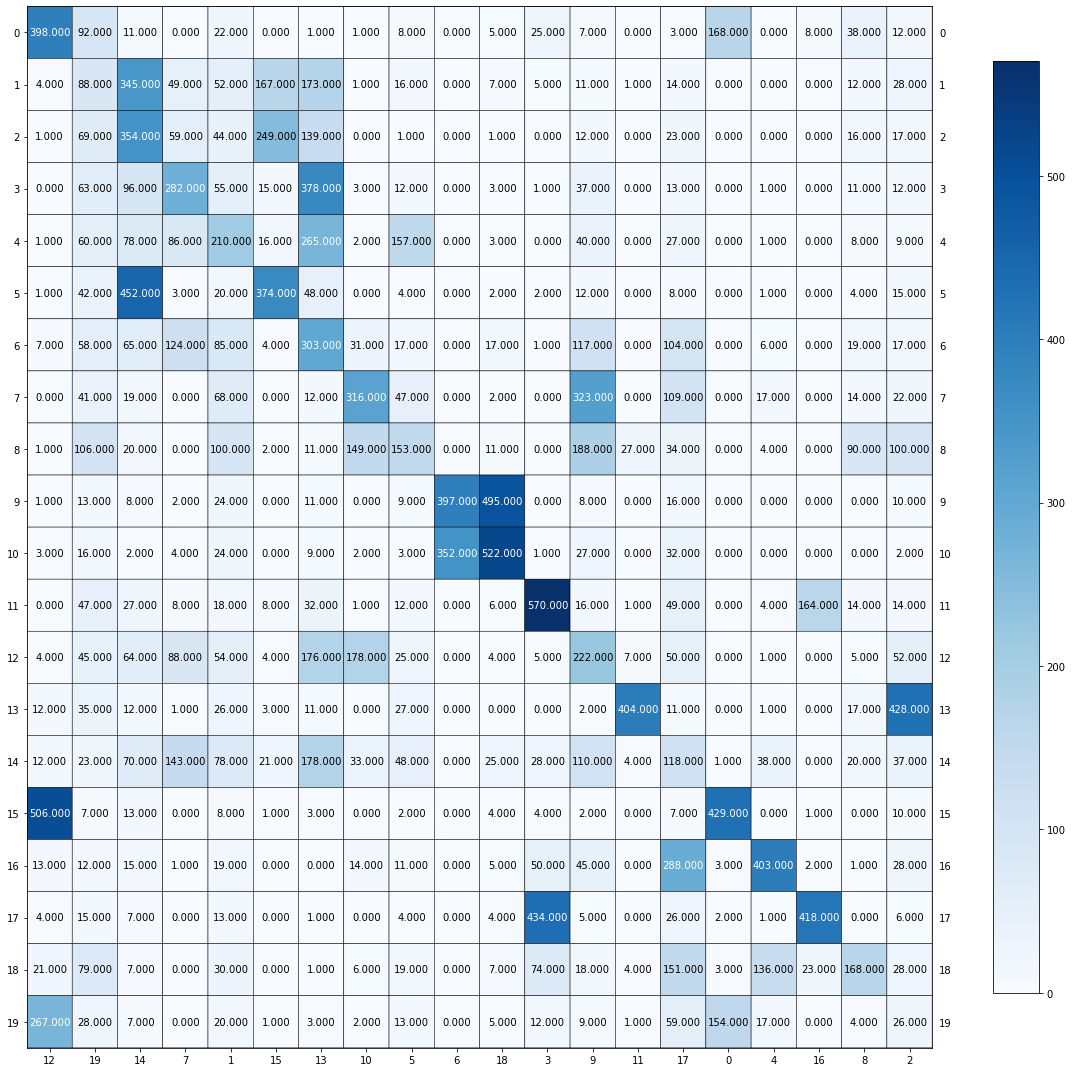

In [66]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

## Q 11

Using UMAP to find the best n_components to reduce the data.

Compared the performance with metric = "eucledian" and metric = "cosine"

In [67]:
import umap

Find best n_components with metric = 'eucledian':

In [68]:
#with metric = 'eucledian'
scores = []
for n in n_components:
    umapfit = umap.UMAP(n_components = n, metric = 'euclidean')
    inputs_umap = umapfit.fit_transform(inputs_tfidf)
    preds = km.fit_predict(inputs_umap)
    get_cluster_metrics(labels, preds)
    scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=metrics, index=n_components)
metrics_df

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
1,0.313804,0.328794,0.321124,0.205228,0.318863
2,0.468820,0.486809,0.477645,0.369443,0.475912
3,0.489580,0.515532,0.502221,0.392948,0.500556
5,0.499953,0.532349,0.515643,0.392992,0.514013
10,0.497766,0.537320,0.516788,0.396259,0.515141
20,0.502224,0.543511,0.522052,0.402544,0.520413
50,0.508013,0.546018,0.526330,0.409757,0.524718
100,0.514402,0.542460,0.528059,0.419452,0.526467
300,0.515771,0.535938,0.525661,0.417134,0.524086


Using metric ='eucledian', best n_components is 5 (n_components = 300 gives metrics superior only in the third decimal of the fraction)

The evaluation metrics and contingency matrix in this case would be:

In [69]:
inputs_umap = umap.UMAP(n_components = 5, metric = 'euclidean').fit_transform(inputs_tfidf)
preds = km.fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.511601
1,completeness_score,0.531974
2,v_measure_score,0.521589
3,adjusted_rand_score,0.414142
4,adjusted_mutual_info_score,0.520000


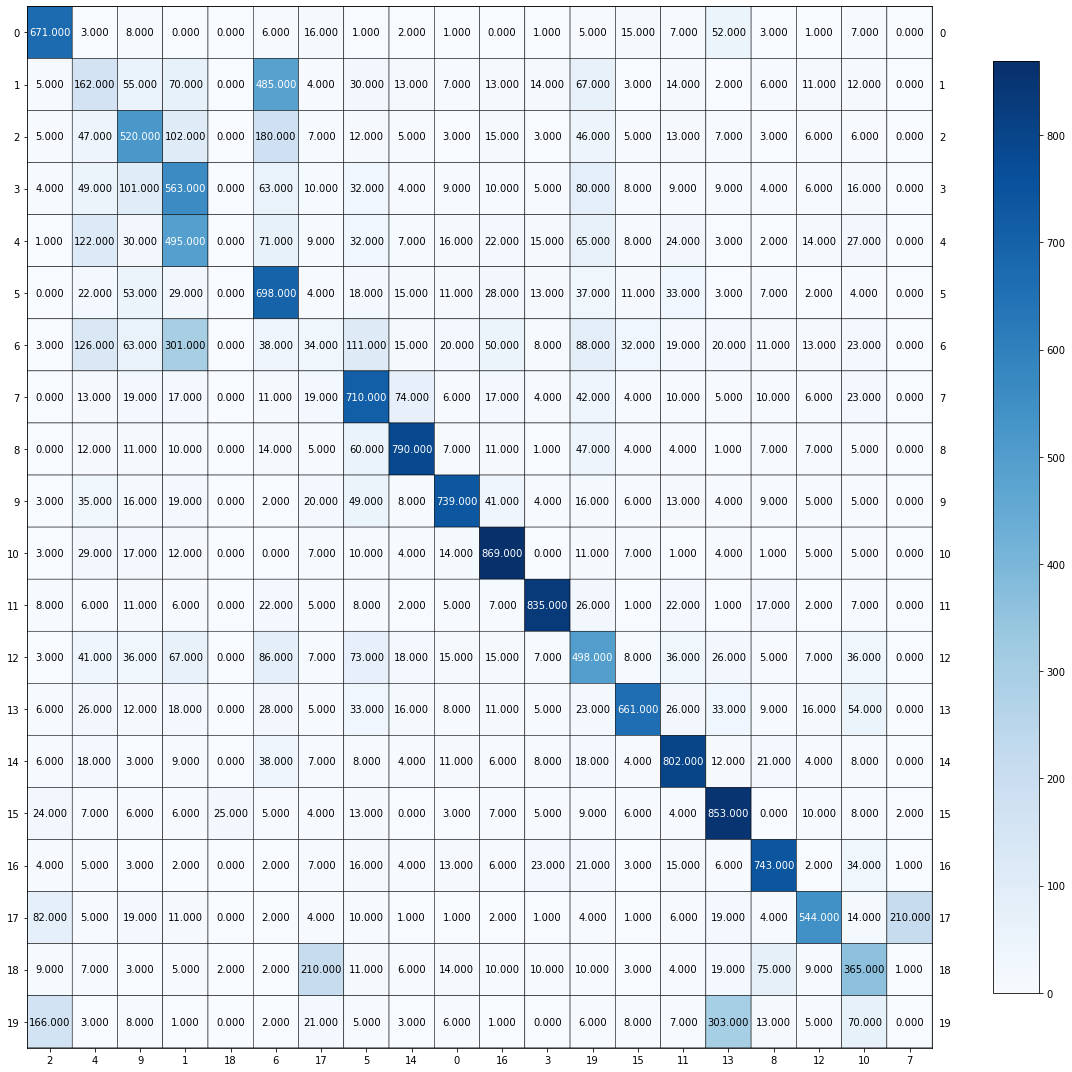

In [70]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

Find best n_components with metric = 'cosine':

In [71]:
#with metric = 'cosine'
scores = []
for n in n_components:
    umapfit = umap.UMAP(n_components = n, metric = 'cosine')
    inputs_umap = umapfit.fit_transform(inputs_tfidf)
    preds = km.fit_predict(inputs_umap)
    get_cluster_metrics(labels, preds)
    scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=metrics, index=n_components)
metrics_df

,homogeneity_score,completeness_score,v_measure_score,adjusted_rand_score,adjusted_mutual_info_score
1,0.326141,0.337057,0.331509,0.220160,0.329310
2,0.475285,0.491008,0.483019,0.375309,0.481307
3,0.485451,0.509786,0.497321,0.393881,0.495632
5,0.501004,0.532950,0.516484,0.399789,0.514858
10,0.502372,0.530903,0.516244,0.407605,0.514623
20,0.510078,0.531100,0.520377,0.414975,0.518783
50,0.500182,0.541944,0.520227,0.394553,0.518588
100,0.498076,0.534279,0.515543,0.387900,0.513894
300,0.497215,0.537664,0.516649,0.394478,0.515015


Using metric = 'cosine', best n_components is: 3 (however, n_components = 5 also give very close metrics)

The evaluation metrics and contingency matrices (using n_components = 3) are:

In [72]:
inputs_umap = umap.UMAP(n_components = 3, metric = 'cosine').fit_transform(inputs_tfidf)
preds = km.fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.491172
1,completeness_score,0.505385
2,v_measure_score,0.498177
3,adjusted_rand_score,0.394992
4,adjusted_mutual_info_score,0.496519


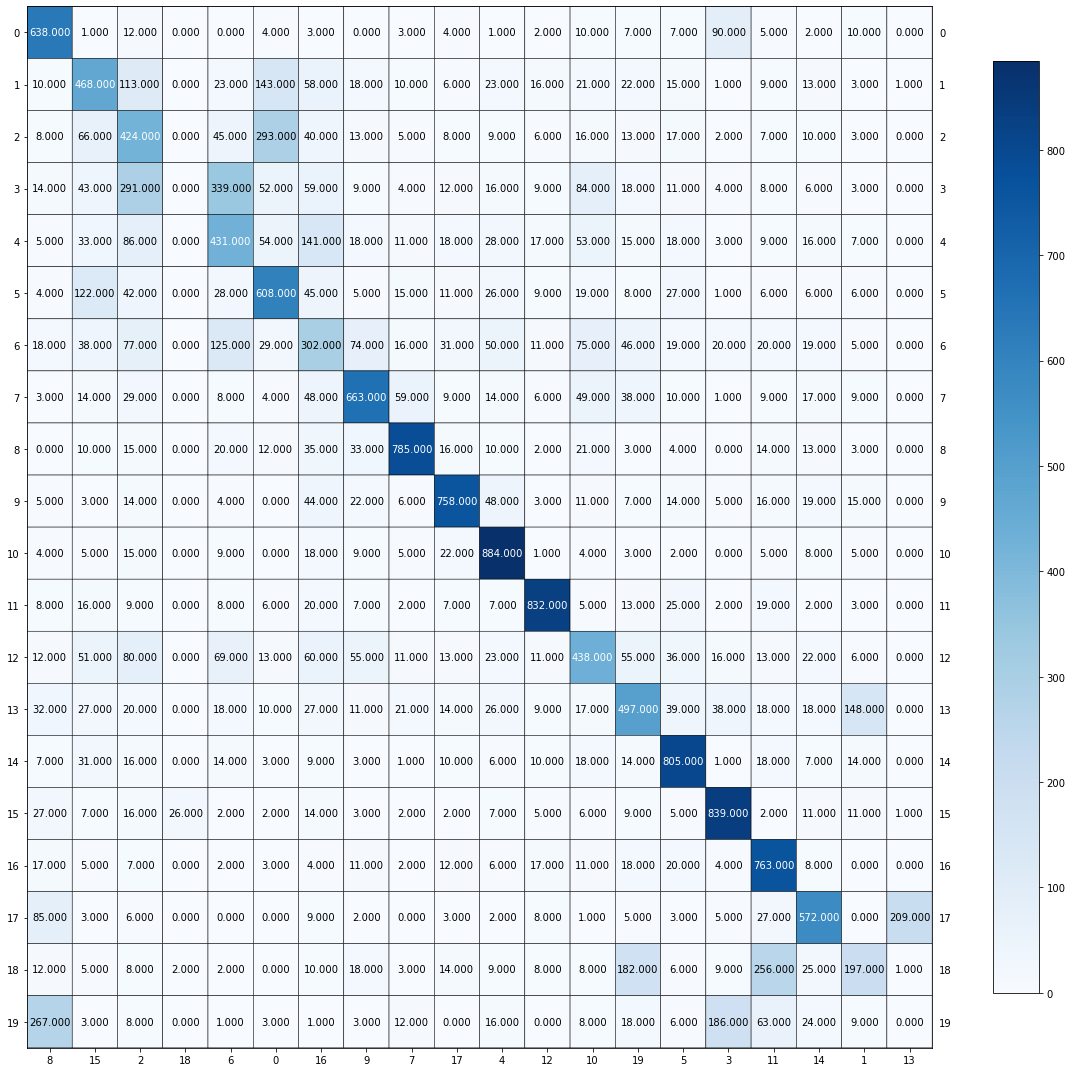

In [73]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

In [74]:
inputs_umap = umap.UMAP(n_components = 5, metric = 'cosine').fit_transform(inputs_tfidf)
preds = km.fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.496043
1,completeness_score,0.526163
2,v_measure_score,0.510659
3,adjusted_rand_score,0.396662
4,adjusted_mutual_info_score,0.509003


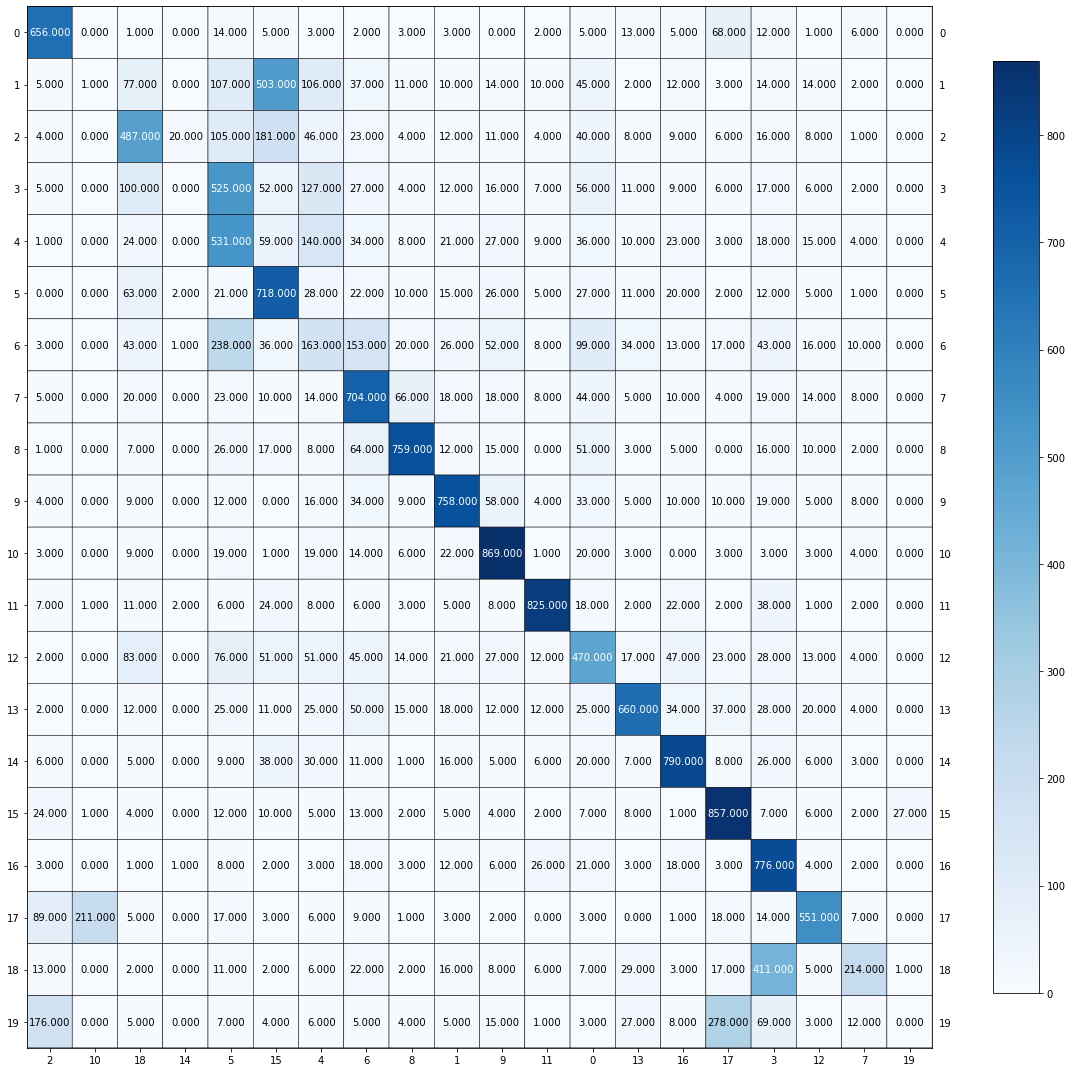

In [75]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

## Q 12: Analyze the contingency matrix:

war

## Q 13 Agglomerative clustering

Comparison for 'ward' and 'single' linkage criteria.

Used UMAP with metric = 'cosine' and n_components = 3, as it gave the best results for k means in the above task

In [44]:
from sklearn.cluster import AgglomerativeClustering

Using 'ward' linkage:

In [46]:
inputs_umap = umap.UMAP(n_components = 3, metric = 'cosine').fit_transform(inputs_tfidf)

agglo = AgglomerativeClustering(n_clusters = len(target_names), linkage = 'ward')
preds = agglo.fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.495834
1,completeness_score,0.510624
2,v_measure_score,0.503120
3,adjusted_rand_score,0.391852
4,adjusted_mutual_info_score,0.501491


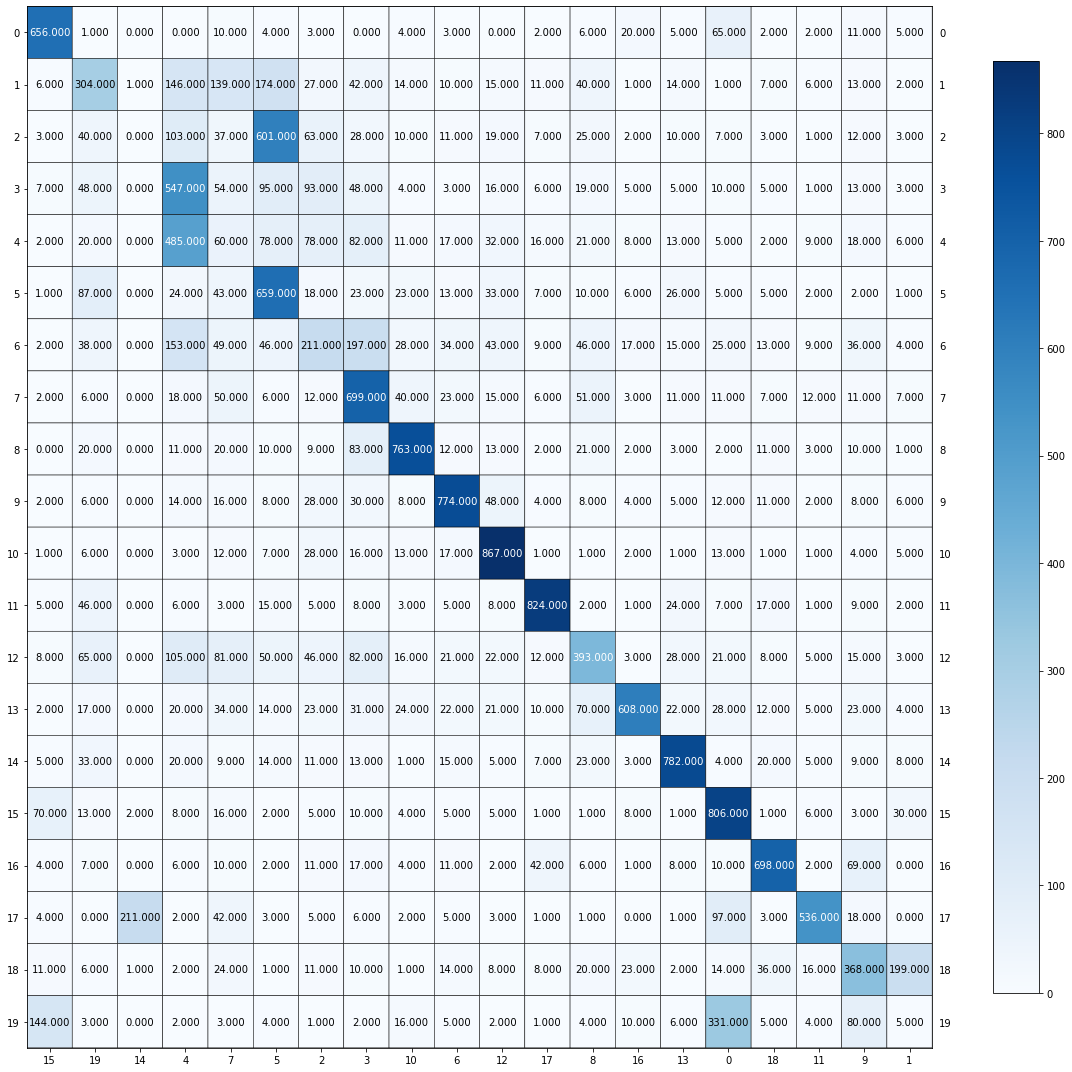

In [47]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

Using 'single' linkage:

# Extremely poor performance (war)

In [48]:
agglo = AgglomerativeClustering(n_clusters = len(target_names), linkage = 'single')
preds = agglo.fit_predict(inputs_umap)
get_cluster_metrics(labels, preds)

,metric,score
0,homogeneity_score,0.053183
1,completeness_score,0.435936
2,v_measure_score,0.094801
3,adjusted_rand_score,0.005671
4,adjusted_mutual_info_score,0.089461


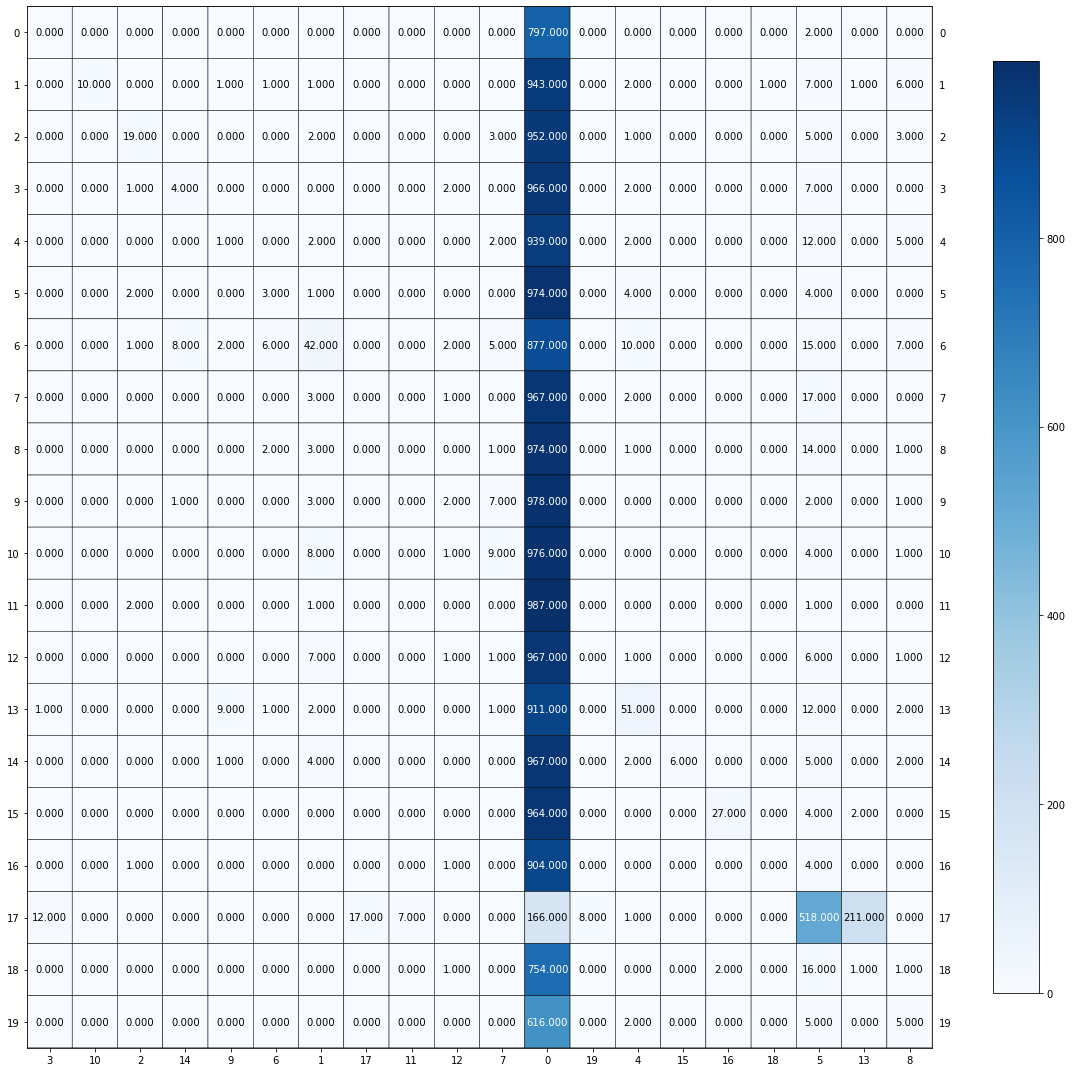

In [49]:
cm = contingency_matrix(labels, preds)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,15))

## 13.

DBSCAN and HDBSCAN using min_cluster_size = 100

Experimenting on the hyperparameters:

Load HDBSCAN: https://pypi.org/project/hdbscan/

Link: https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html?highlight=dbscan#dbscan

Link: https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/#:~:text=Two%20important%20parameters%20are%20required,neighbors%20within%20%E2%80%9Ceps%E2%80%9D%20radius.

Link:https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc#:~:text=DBSCAN%20works%20by%20determining%20whether,maximum%20distance%20between%20two%20points.

## DBSCAN

Let epsilon vary from 0.05 to 1, in steps of 0.05 and min_samples vary from 5 to 500 in steps of 10

In [8]:
from sklearn.cluster import DBSCAN
inputs_umap = umap.UMAP(n_components = 5, metric = 'cosine').fit_transform(inputs_tfidf)

In [57]:
eps_list = [x * 0.05 for x in range(1, 21)]
min_samples_list = list(range(5,500,10))

scores = []
for ep in eps_list:
    for min_samp in min_samples_list:
        preds = DBSCAN(eps = ep, min_samples = min_samp, n_jobs = -1).fit_predict(inputs_umap)
        row = get_cluster_metrics(labels, preds)['score'].tolist()
        row.append(ep)
        row.append(min_samp)
        scores.append(row)
        #scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
        
titles = get_cluster_metrics(labels, preds)['metric'].tolist()
titles.append("Epsilon")
titles.append("min_samples")
#metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=titles)
metrics_df.to_excel('DBSCAN.xlsx')

In [66]:
conda install -c conda-forge hdbscan

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\sriva\anaconda3

  added / updated specs:
    - hdbscan


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    hdbscan-0.8.26             |   py38h347fdf6_3         506 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         506 KB

The following NEW packages will be INSTALLED:

  hdbscan            conda-forge/win-64::hdbscan-0.8.26-py38h347fdf6_3




hdbscan-0.8.26       | 506 KB    |            |   0% 
hdbscan-0.8.26       | 506 KB    | 3          |   3% 
hdbscan-0.8.26       | 506 KB    | ########## | 100% 
hdbscan-0.8.26       | 506 KB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart 

## HDBSCAN

In [9]:
import hdbscan

In [13]:
clust_eps_list = [x * 0.05 for x in range(1, 21)]
min_samples_list = list(range(5,500,10))

scores = []
for ep in clust_eps_list:
    for min_samp in min_samples_list:
        preds = hdbscan.HDBSCAN(min_cluster_size=100, min_samples = min_samp, cluster_selection_epsilon = ep, core_dist_n_jobs=-1).fit_predict(inputs_umap)
        row = get_cluster_metrics(labels, preds)['score'].tolist()
        row.append(ep)
        row.append(min_samp)
        scores.append(row)
        #scores.append(get_cluster_metrics(labels, preds)['score'].tolist())
        
titles = get_cluster_metrics(labels, preds)['metric'].tolist()
titles.append("Cluster_sel_Epsilon")
titles.append("min_samples")
#metrics = get_cluster_metrics(labels, preds)['metric'].tolist()
metrics_df = pd.DataFrame(scores, columns=titles)
metrics_df.to_excel('HDBSCAN.xlsx')

(War) Report cluster metrics and tell what are the best dbscan and hdbscan parameters(after looking through the excel sheets)

Plot contingency matrix for the best model. How many clusters are given? What does -1 mean for the labels ( I think noise, but have to check) Inerpret the contingency matrices while answering these questions

